<a href="https://colab.research.google.com/github/hosseinnasi/Environmental-Classification_ML/blob/main/wifi_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from collections import Counter

from sklearn.inspection import permutation_importance
from scikeras.wrappers import KerasClassifier
import shap

In [ ]:
# Load each dataset
data_indoor_interior = pd.read_csv('ii5.csv')
data_indoor_window = pd.read_csv('inw5.csv')
data_outdoor = pd.read_csv('o5.csv')

# Assign labels
data_indoor_interior['environment'] = 0
data_indoor_window['environment'] = 1
data_outdoor['environment'] = 2

# Concatenate all datasets
combined_data = pd.concat([data_indoor_interior, data_indoor_window, data_outdoor], ignore_index=True)

# Save the combined dataset
combined_data.to_csv('combined_data.csv', index=False)

In [ ]:
combined_data.shape

(67957, 78)

In [ ]:
# Filter columns related to Wi-Fi signals
wifi_columns = ['num_of_wifi_2_4', 'num_of_wifi_5', 'num_of_wifi_6',
                'avg_rssi_of_wifi_2_4', 'avg_rssi_of_wifi_5', 'avg_rssi_of_wifi_6',
                'std_wifi_2_4_rssi', 'std_wifi_5_rssi', 'std_wifi_6_rssi',
                'max_of_wifi_2_4', 'min_of_wifi_2_4', 'max_of_wifi_5', 'min_of_wifi_5',
                'max_of_wifi_6', 'min_of_wifi_6']
data=combined_data

Y = data['environment']

# Split the dataset
X_train_all, X_test_all, Y_train, Y_test = train_test_split(data, Y, test_size=0.2, stratify=Y)

X_train=X_train_all[wifi_columns]
X_test=X_test_all[wifi_columns]

# Scale the features
train_scaler = preprocessing.StandardScaler().fit(X_train)
X_train_s = train_scaler.transform(X_train)
X_test_s = train_scaler.transform(X_test)

# Encode the labels
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # First dense layer
    Dense(64, activation='relu'),  # Second dense layer
    Dense(3, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_s, y_train, validation_split=0.33, epochs=50, batch_size=128)

Epoch 1/50


C:\Users\hosse\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7452 - loss: 0.6135 - val_accuracy: 0.8761 - val_loss: 0.3467
Epoch 2/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8827 - loss: 0.3244 - val_accuracy: 0.8950 - val_loss: 0.2809
Epoch 3/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9042 - loss: 0.2637 - val_accuracy: 0.9014 - val_loss: 0.2598
Epoch 4/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9144 - loss: 0.2331 - val_accuracy: 0.9120 - val_loss: 0.2338
Epoch 5/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9201 - loss: 0.2252 - val_accuracy: 0.9189 - val_loss: 0.2212
Epoch 6/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9247 - loss: 0.2104 - val_accuracy: 0.9256 - val_loss: 0.2089
Epoch 7/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9261 - loss: 0.2029 - val_accuracy: 0.9264 - val_loss: 0.2106
Epoch 8/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9299 - loss: 0.1946 - val_accuracy: 0.9288 - val_

In [ ]:

# Decision Tree Model
tree_model = DecisionTreeClassifier(max_depth=10, min_samples_split=20, min_samples_leaf=10)
tree_model.fit(X_train_s, Y_train)


# Rando Forest
forest_model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=15, min_samples_leaf=5)
forest_model.fit(X_train_s, Y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=15,
                       n_estimators=200)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Predict on test data
y_pred_nn = model.predict(X_test_s)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)  # Convert probabilities to class labels

# Calculate accuracy
nn_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_nn_classes)
print("Neural Network Accuracy:", nn_accuracy)

# Confusion Matrix
nn_confusion_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_nn_classes)
nn_confusion_matrix = nn_confusion_matrix.astype('float') / nn_confusion_matrix.sum(axis=1)[:, np.newaxis]
nn_confusion_matrix *= 100  # convert to percentage
nn_confusion_matrix = np.round(nn_confusion_matrix, 2)
print("Neural Network Confusion Matrix:\n", nn_confusion_matrix)

# Classification report
nn_classification_report = classification_report(np.argmax(y_test, axis=1), y_pred_nn_classes)
print("Neural Network Classification Report:\n", nn_classification_report)


425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
Neural Network Accuracy: 0.9448204826368451
Neural Network Confusion Matrix:
 [[93.12  4.28  2.61]
 [ 3.96 92.66  3.38]
 [ 2.23  0.41 97.35]]
Neural Network Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      4561
           1       0.95      0.93      0.94      4195
           2       0.95      0.97      0.96      4836

    accuracy                           0.94     13592
   macro avg       0.94      0.94      0.94     13592
weighted avg       0.94      0.94      0.94     13592



In [ ]:
# Predict on test data
y_pred_dt = tree_model.predict(X_test_s)

# Calculate accuracy
dt_accuracy = accuracy_score(Y_test, y_pred_dt)
print("Decision Tree Accuracy:", dt_accuracy)

# Confusion Matrix
dt_confusion_matrix = confusion_matrix(Y_test, y_pred_dt)
dt_confusion_matrix = dt_confusion_matrix.astype('float') / dt_confusion_matrix.sum(axis=1)[:, np.newaxis]
dt_confusion_matrix *= 100  # convert to percentage
dt_confusion_matrix = np.round(dt_confusion_matrix, 2)
print("Decision Tree Confusion Matrix:\n", dt_confusion_matrix)

# Classification report
dt_classification_report = classification_report(Y_test, y_pred_dt)
print("Decision Tree Classification Report:\n", dt_classification_report)


Decision Tree Accuracy: 0.9059005297233667
Decision Tree Confusion Matrix:
 [[87.13  8.9   3.97]
 [ 6.75 91.42  1.84]
 [ 2.25  4.61 93.13]]
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      4561
           1       0.86      0.91      0.89      4195
           2       0.95      0.93      0.94      4836

    accuracy                           0.91     13592
   macro avg       0.91      0.91      0.90     13592
weighted avg       0.91      0.91      0.91     13592



In [ ]:
# Predict on test data
y_pred_rf = forest_model.predict(X_test_s)

# Calculate accuracy
rf_accuracy = accuracy_score(Y_test, y_pred_rf)
print("Random Forest Accuracy:", rf_accuracy)

# Confusion Matrix
rf_confusion_matrix = confusion_matrix(Y_test, y_pred_rf)
rf_confusion_matrix = rf_confusion_matrix.astype('float') / rf_confusion_matrix.sum(axis=1)[:, np.newaxis]
rf_confusion_matrix *= 100  # convert to percentage
rf_confusion_matrix = np.round(rf_confusion_matrix, 2)
print("Random Forest Confusion Matrix:\n", rf_confusion_matrix)

# Classification report
rf_classification_report = classification_report(Y_test, y_pred_rf)
print("Random Forest Classification Report:\n", rf_classification_report)


Random Forest Accuracy: 0.9301795173631549
Random Forest Confusion Matrix:
 [[91.41  5.63  2.96]
 [ 6.63 90.68  2.69]
 [ 2.52  0.91 96.57]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      4561
           1       0.93      0.91      0.92      4195
           2       0.95      0.97      0.96      4836

    accuracy                           0.93     13592
   macro avg       0.93      0.93      0.93     13592
weighted avg       0.93      0.93      0.93     13592



In [ ]:
Period=6;
# Ensure the data is sorted by time_counter, environment, and sim_operator
X_test_all.sort_values(by=['time_counter', 'environment', 'sim_operator'], inplace=True)

# Function to form groups of 6 based on the same environment and sim operator
def form_groups(df):
    # Groups by environment and sim_operator, and form chunks of Period
    groups = []
    temp_group = []

    last_env = None
    last_sim = None

    for index, row in df.iterrows():
        if len(temp_group) < Period and row['environment'] == last_env and row['sim_operator'] == last_sim:
            temp_group.append(row)
        else:
            if len(temp_group) == Period:
                groups.append(temp_group)
            temp_group = [row]

        last_env = row['environment']
        last_sim = row['sim_operator']

    # Check the last group in case it's full
    if len(temp_group) == Period:
        groups.append(temp_group)

    return groups

# Apply the grouping function
grouped_data = form_groups(X_test_all)


In [ ]:
def majority_vote(predictions):
    # Count the frequency of each number in the vector
    counts = Counter(predictions)
    # Get the highest frequency
    max_frequency = max(counts.values())
    # Find all items that have the highest frequency
    most_frequent = [num for num, freq in counts.items() if freq == max_frequency]
    # Return the maximum number among those with the highest frequency
    return max(most_frequent)

# Predict for each group and apply majority voting
final_predictions = []
True_label=[]

for group in grouped_data:
    group_df = pd.DataFrame(group)
    X_group = group_df[wifi_columns]  # Assuming wifi_columns are the features for your models
    Y_group=pd.unique(group_df['environment'])
    # Standardize features as the models were trained on standardized data
    X_group_scaled = train_scaler.transform(X_group)

    # Get predictions from each model
    nn_preds = np.argmax(model.predict(X_group_scaled), axis=1)
    dt_preds = tree_model.predict(X_group_scaled)
    rf_preds = forest_model.predict(X_group_scaled)

    # Combine predictions
    all_preds = np.vstack([nn_preds, dt_preds, rf_preds])

    # Vote and select the majority
    voted_class = [majority_vote(all_preds[i, :]) for i in range(3)]
    group_class = majority_vote(voted_class)
    final_predictions.append(voted_class)
    True_label.append(Y_group)

final_predictions=np.squeeze(np.array(final_predictions))
True_label=np.squeeze(np.array(True_label))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

In [ ]:

# Extract predictions for each classifier
nn_predictions = final_predictions[:, 0]
dt_predictions = final_predictions[:, 1]
rf_predictions = final_predictions[:, 2]

# Calculate accuracies
nn_accuracy = accuracy_score(True_label, nn_predictions)
dt_accuracy = accuracy_score(True_label, dt_predictions)
rf_accuracy = accuracy_score(True_label, rf_predictions)

# Calculate confusion matrices
nn_conf_matrix = confusion_matrix(True_label, nn_predictions)
dt_conf_matrix = confusion_matrix(True_label, dt_predictions)
rf_conf_matrix = confusion_matrix(True_label, rf_predictions)

# Convert confusion matrices to percentages
nn_conf_matrix_percentage = np.round(nn_conf_matrix.astype('float') / nn_conf_matrix.sum(axis=1)[:, np.newaxis] * 100, 2)
dt_conf_matrix_percentage = np.round(dt_conf_matrix.astype('float') / dt_conf_matrix.sum(axis=1)[:, np.newaxis] * 100, 2)
rf_conf_matrix_percentage = np.round(rf_conf_matrix.astype('float') / rf_conf_matrix.sum(axis=1)[:, np.newaxis] * 100, 2)

# Print results
print("Neural Network Accuracy:", nn_accuracy)
print("Neural Network Confusion Matrix:\n", nn_conf_matrix_percentage)

print("Decision Tree Accuracy:", dt_accuracy)
print("Decision Tree Confusion Matrix:\n", dt_conf_matrix_percentage)

print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Confusion Matrix:\n", rf_conf_matrix_percentage)


Neural Network Accuracy: 0.994475138121547
Neural Network Confusion Matrix:
 [[100.     0.     0.  ]
 [  2.38  97.62   0.  ]
 [  0.     0.   100.  ]]
Decision Tree Accuracy: 0.9779005524861878
Decision Tree Confusion Matrix:
 [[ 98.15   1.85   0.  ]
 [  0.   100.     0.  ]
 [  0.     6.45  93.55]]
Random Forest Accuracy: 0.988950276243094
Random Forest Confusion Matrix:
 [[100.     0.     0.  ]
 [  4.76  95.24   0.  ]
 [  0.     0.   100.  ]]


C:\Users\hosse\AppData\Local\Temp\ipykernel_12760\4049319796.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, x='environment', y=col_name, data=df_filtered, palette=palette)
C:\Users\hosse\AppData\Local\Temp\ipykernel_12760\4049319796.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, x='environment', y=col_name, data=df_filtered, palette=palette)
C:\Users\hosse\AppData\Local\Temp\ipykernel_12760\4049319796.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, x='environment', y=col_name, data=df_filtered, palette=p

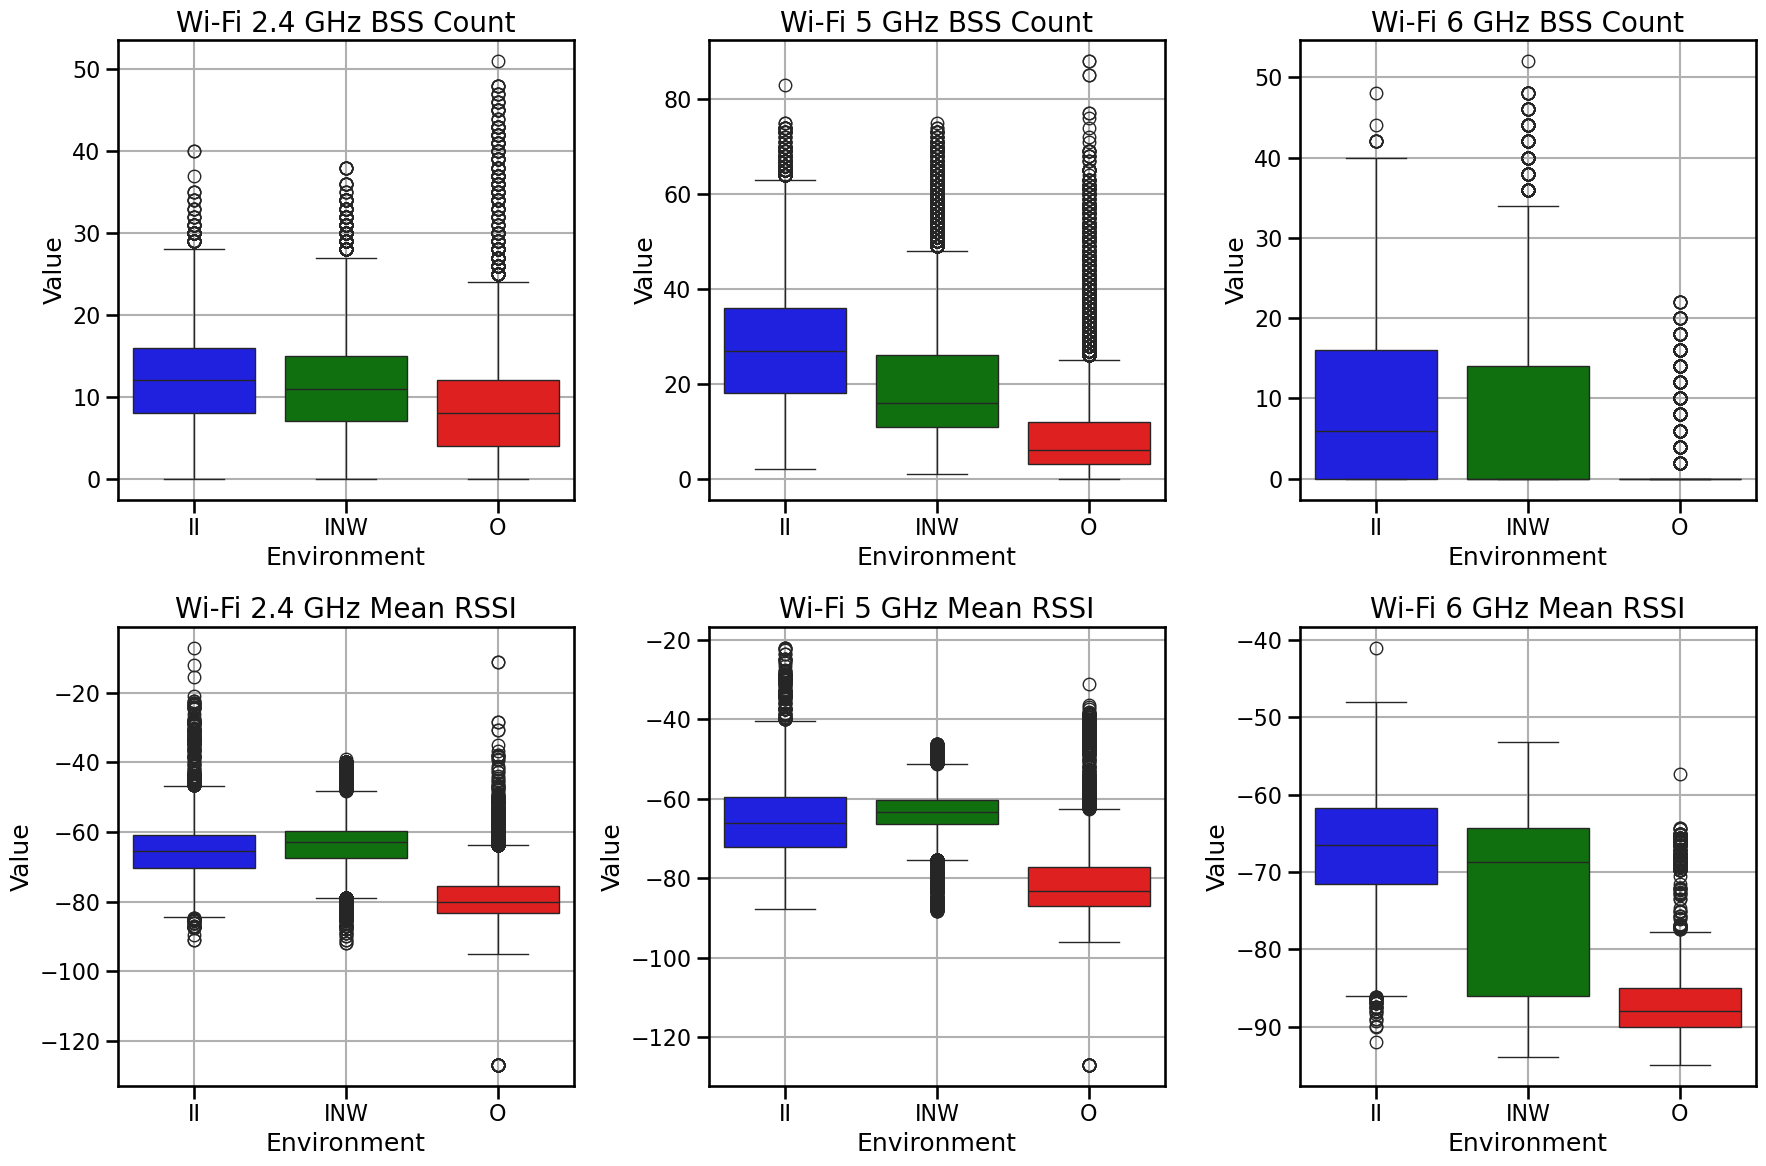

In [ ]:

# Assuming the DataFrames are already defined and have an 'environment' column set
data_indoor_interior['environment'] = 'II'
data_indoor_window['environment'] = 'INW'
data_outdoor['environment'] = 'O'

# Combine the dataframes
frames = [data_indoor_interior, data_indoor_window, data_outdoor]
df = pd.concat(frames)

# Set up the plotting grid
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns

# Define colors for each environment
palette = {'II': 'blue', 'INW': 'green', 'O': 'red'}

# Define the plotting columns and titles
bands = ['2_4', '5', '6']
metrics = ['num_of_wifi_', 'avg_rssi_of_wifi_']

# Setting larger font sizes globally for seaborn plots
sns.set_context("talk")  # Adjusts the scale of the font sizes from default to larger sizes

for i, metric in enumerate(metrics):
    for j, band in enumerate(bands):
        col_name = f'{metric}{band}'
        ax = axs[i, j]
        if i == 1:
            df_filtered = df[df[col_name] != 0]
        else:
            df_filtered = df

        sns.boxplot(ax=ax, x='environment', y=col_name, data=df_filtered, palette=palette)
        ax.set_title(f'Wi-Fi {band.replace("_", ".")} GHz {("BSS Count" if "num" in metric else "Mean RSSI")}', fontsize=20)
        ax.set_xlabel('Environment', fontsize=18)
        ax.set_ylabel('Value', fontsize=18)

        # Explicitly setting the tick label sizes
        ax.tick_params(axis='both', which='major', labelsize=16)

        ax.grid(True)

plt.tight_layout()
plt.show()


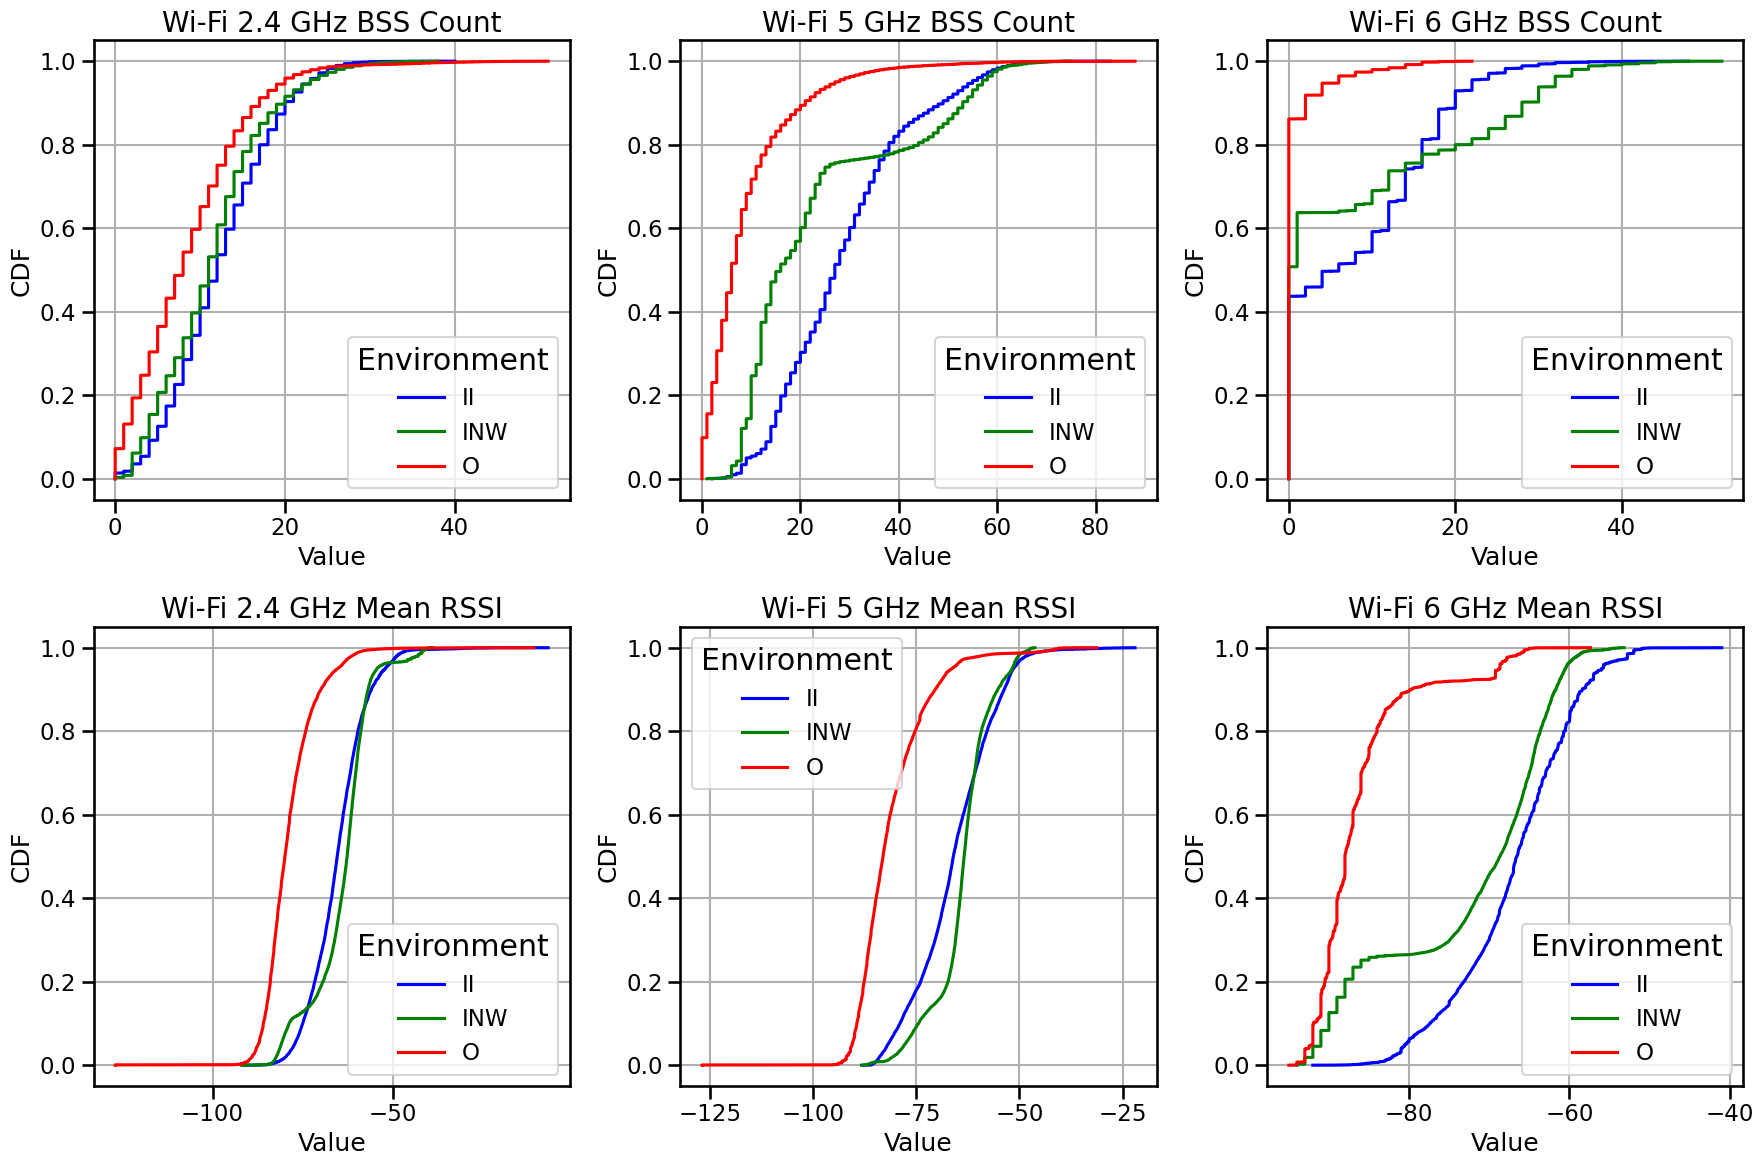

In [ ]:

data_indoor_interior['environment'] = 'II'
data_indoor_window['environment'] = 'INW'
data_outdoor['environment'] = 'O'

# Combine the dataframes
frames = [data_indoor_interior, data_indoor_window, data_outdoor]
df = pd.concat(frames)

# Set up the plotting grid
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns

# Define colors for each environment
colors = {'II': 'blue', 'INW': 'green', 'O': 'red'}

# Define the plotting columns and titles
bands = ['2_4', '5', '6']
metrics = ['num_of_wifi_', 'avg_rssi_of_wifi_']

# Set larger font sizes for plots
sns.set_context("talk")  # 'talk' context is good for larger presentations
plt.rcParams.update({'axes.titlesize': 'large',   # Larger axis titles
                     'axes.labelsize': 'large',   # Larger x and y labels
                     'xtick.labelsize': 'large',  # Larger tick labels
                     'ytick.labelsize': 'large',  # Larger tick labels
                     'legend.title_fontsize': 'large'})  # Larger legend titles

for i, metric in enumerate(metrics):
    for j, band in enumerate(bands):
        ax = axs[i, j]
        col_name = f'{metric}{band}'  # Construct the column name dynamically

        # Loop through each environment to plot CDFs
        for env, color in colors.items():
            # Filter the data for the current environment
            df_filtered = df[df['environment'] == env]
            if i == 1:
                df_filtered = df_filtered[df_filtered[col_name] != 0]

            subset = df_filtered[col_name]
            # Calculate the CDF
            data_sorted = np.sort(subset)
            p = np.arange(len(subset)) / float(len(subset) - 1)  # CDF values

            # Plot the CDF
            ax.plot(data_sorted, p, label=env, color=color)

        ax.set_title(f'Wi-Fi {band.replace("_", ".")} GHz {("BSS Count" if "num" in metric else "Mean RSSI")}', fontsize=20)
        ax.set_xlabel('Value', fontsize=18)
        ax.set_ylabel('CDF', fontsize=18)
        ax.legend(title='Environment')
        ax.grid(True)

plt.tight_layout()
plt.show()


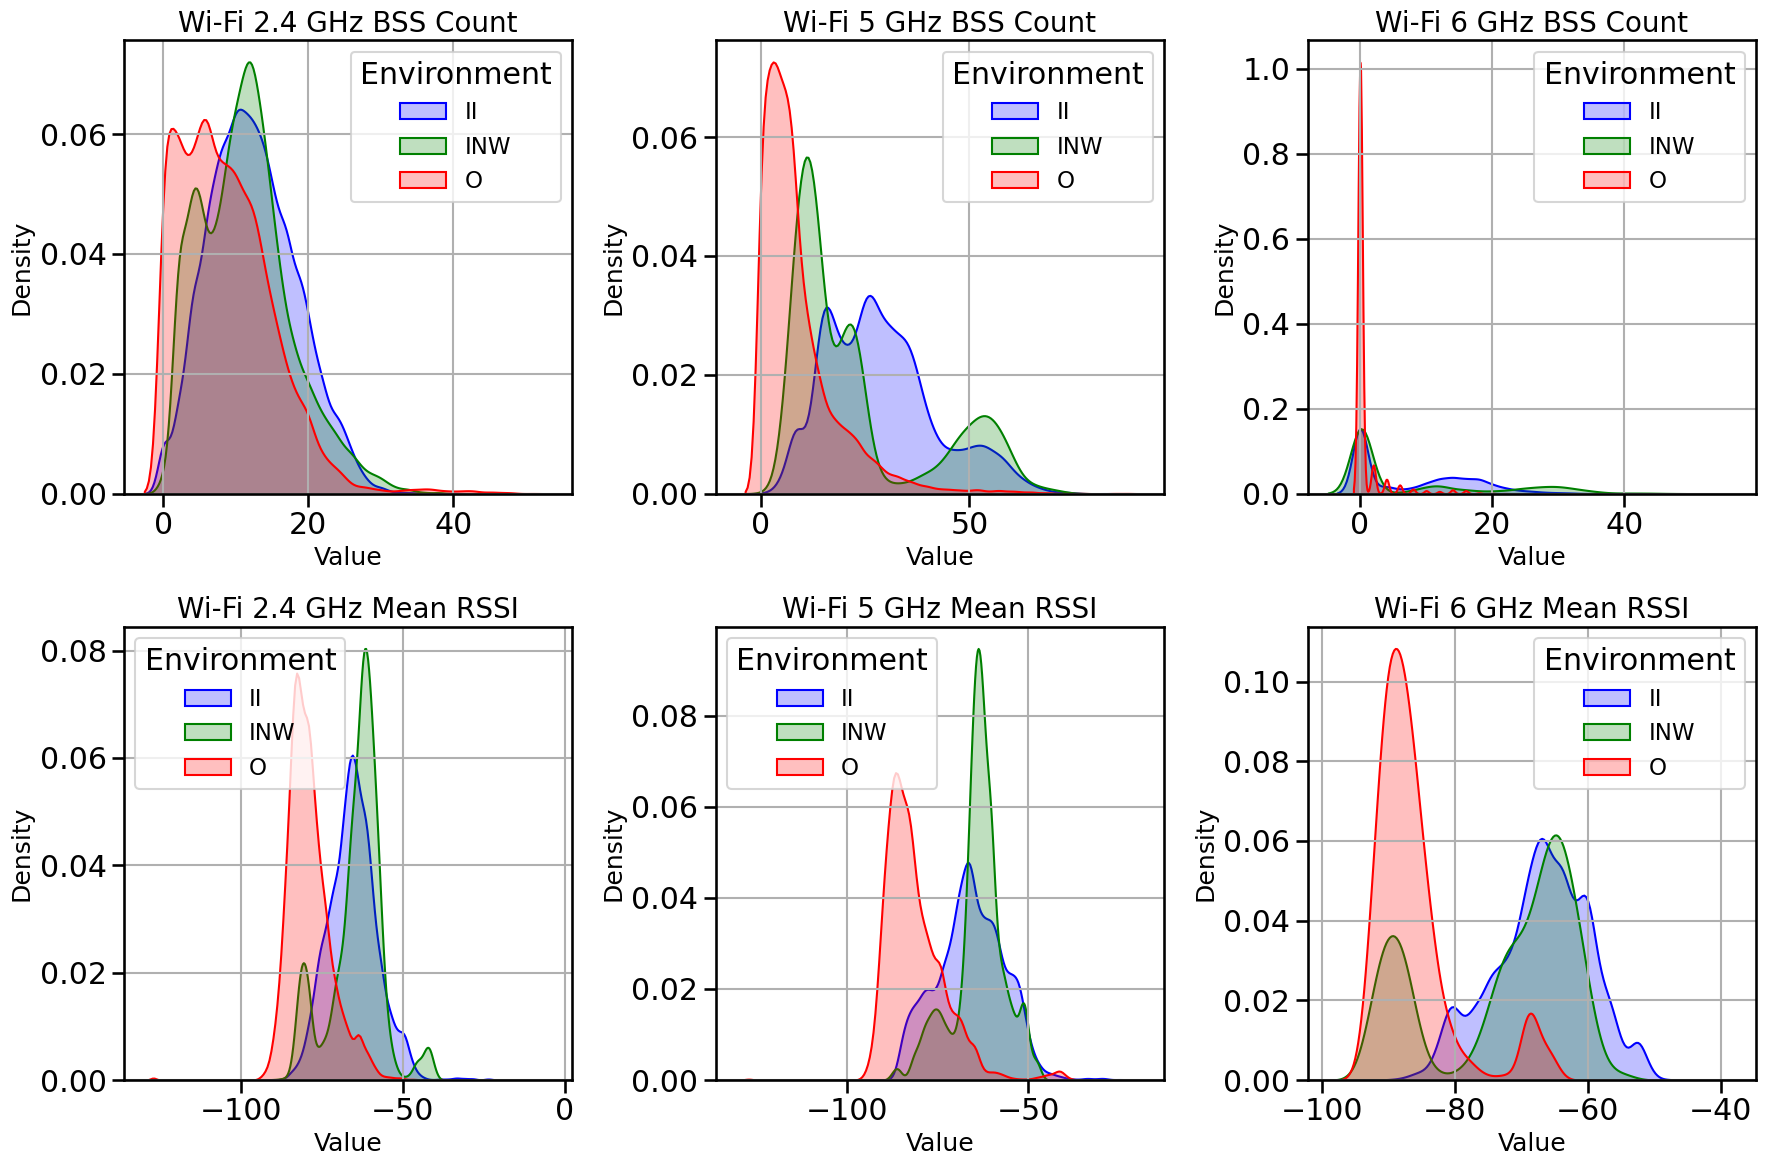

In [ ]:

data_indoor_interior['environment'] = 'II'
data_indoor_window['environment'] = 'INW'
data_outdoor['environment'] = 'O'

# Combine the dataframes
frames = [data_indoor_interior, data_indoor_window, data_outdoor]
df = pd.concat(frames)

# Set up the plotting grid
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns

# Set larger font sizes for plots
sns.set_context("talk")  # 'talk' context is good for larger presentations
plt.rcParams.update({'axes.titlesize': 'large',   # Larger axis titles
                     'axes.labelsize': 'large',   # Larger x and y labels
                     'xtick.labelsize': 'large',  # Larger tick labels
                     'ytick.labelsize': 'large',  # Larger tick labels
                     'legend.title_fontsize': 'large'})  # Larger legend titles

# Define colors for each environment
colors = {'II': 'blue', 'INW': 'green', 'O': 'red'}

# Define the plotting columns and titles
bands = ['2_4', '5', '6']
metrics = ['num_of_wifi_', 'avg_rssi_of_wifi_']

for i, metric in enumerate(metrics):
    for j, band in enumerate(bands):
        ax = axs[i, j]
        col_name = f'{metric}{band}'  # Construct the column name dynamically

        # Loop through each environment to plot PDFs
        for env, color in colors.items():
            # Filter the data for the current environment
            df_filtered = df[df['environment'] == env]
            if i == 1:
                df_filtered = df_filtered[df_filtered[col_name] != 0]

            subset = df_filtered[col_name]
            # Plot the PDF using KDE
            sns.kdeplot(subset, ax=ax, color=color, label=env, fill=True)

        ax.set_title(f'Wi-Fi {band.replace("_", ".")} GHz {("BSS Count" if "num" in metric else "Mean RSSI")}', fontsize=20)
        ax.set_xlabel('Value', fontsize=18)
        ax.set_ylabel('Density', fontsize=18)
        ax.legend(title='Environment')
        ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
#!pip install eli5
#!pip install PermutationImportance

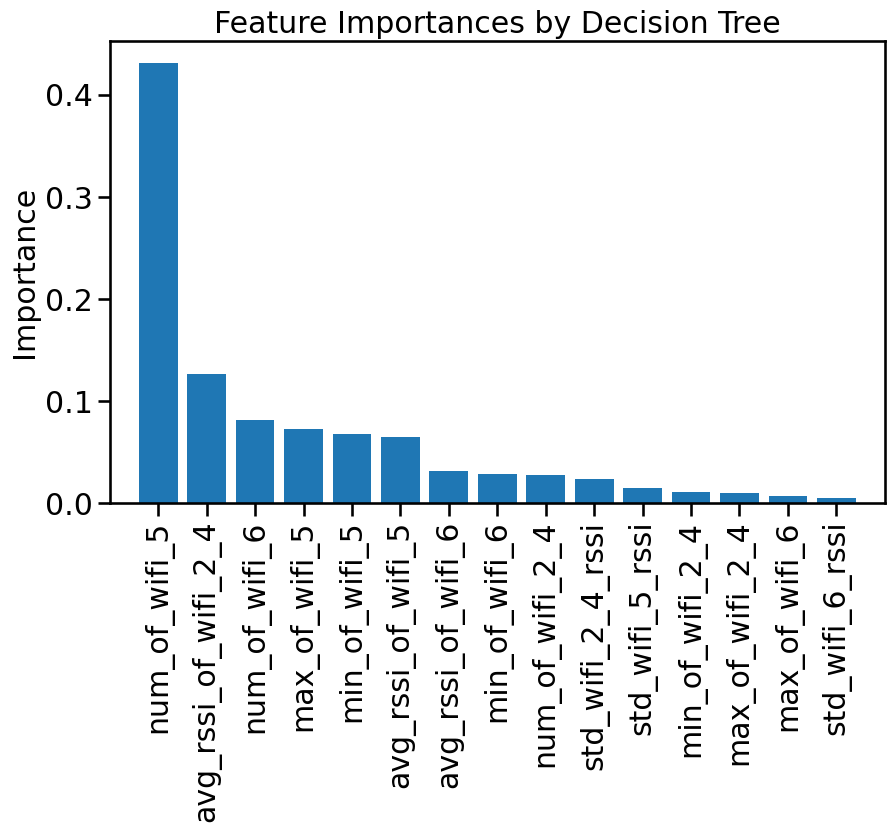

In [ ]:
# Get feature importances
importances = tree_model.feature_importances_
indices = np.argsort(importances)[::-1]
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances by Decision Tree')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.ylabel('Importance')
plt.show()

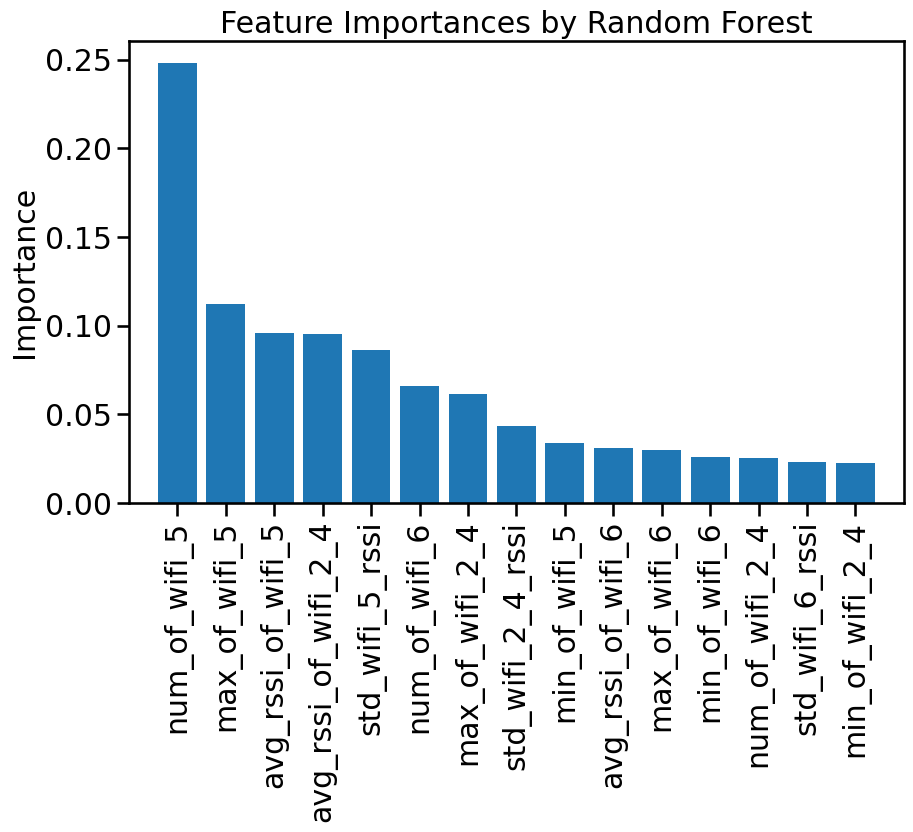

In [ ]:
# Get feature importances
importances = forest_model.feature_importances_
indices = np.argsort(importances)[::-1]
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances by Random Forest')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.ylabel('Importance')
plt.show()

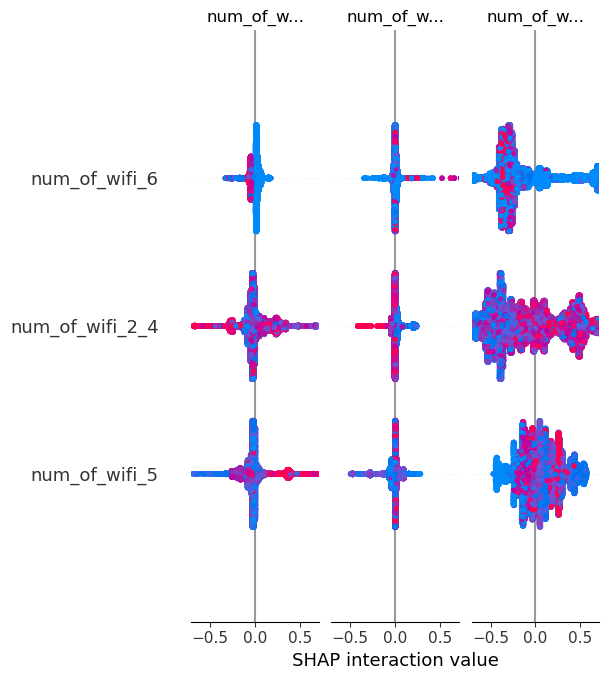

In [ ]:
# Explain model predictions using SHAP
explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X_train_s)

# Plot SHAP values for one prediction
shap.summary_plot(shap_values, X_train_s, plot_type="bar",feature_names=X_train.columns)

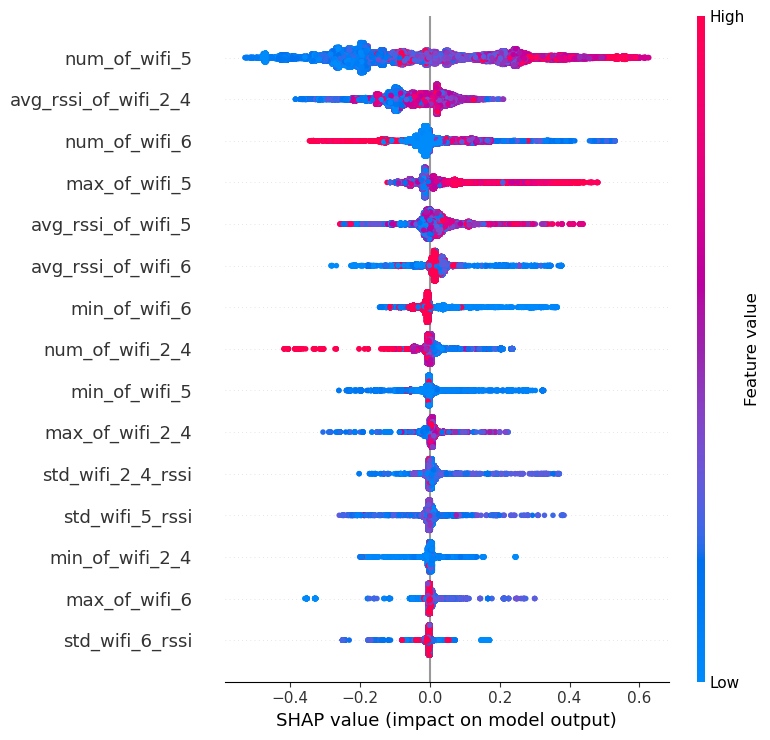

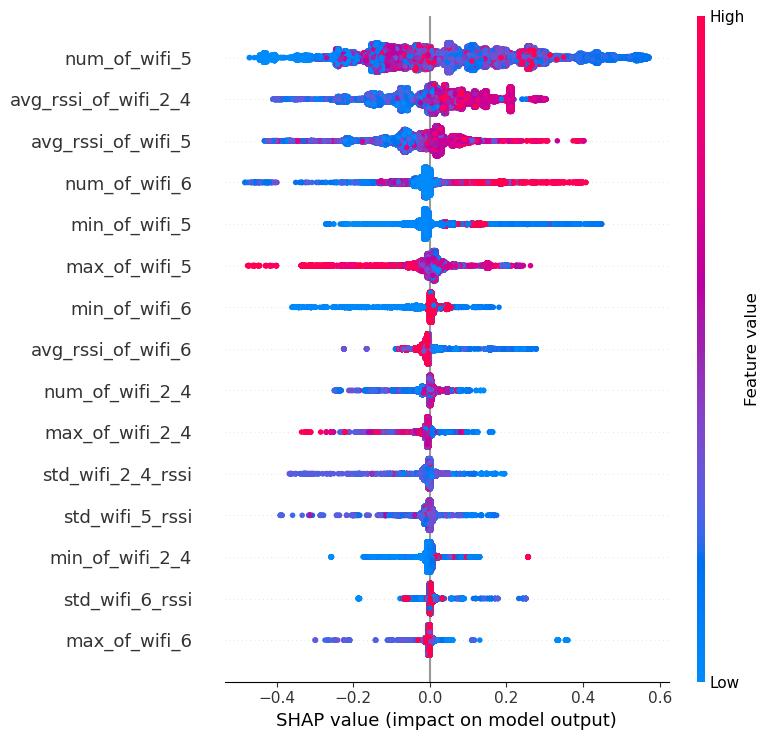

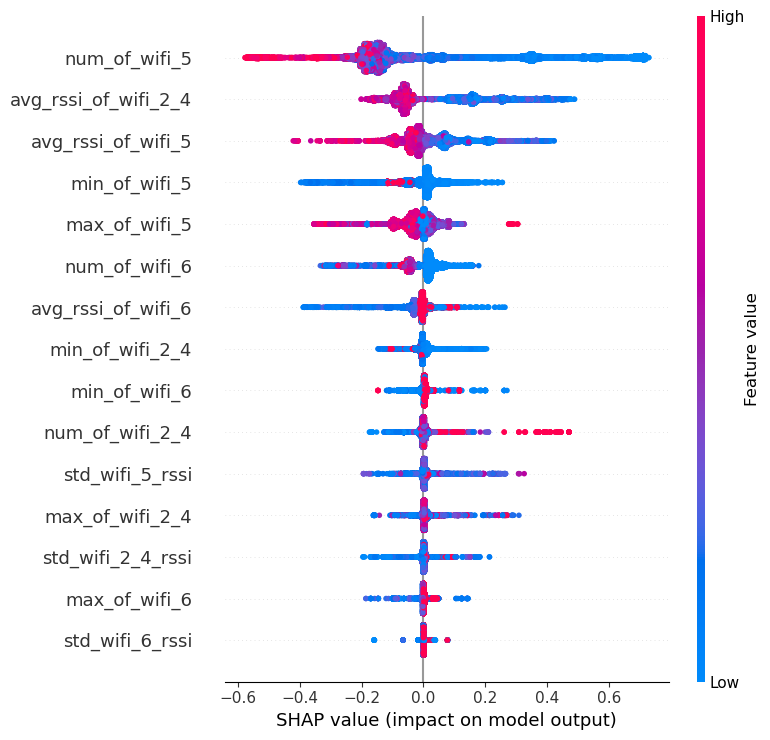

In [ ]:
# Select SHAP values for the first class
for i in range(3):
    shap_values_for_class = shap_values[:, :, i]
    # Plot SHAP summary for the first class
    shap.summary_plot(shap_values_for_class, X_train_s, feature_names=X_train.columns)

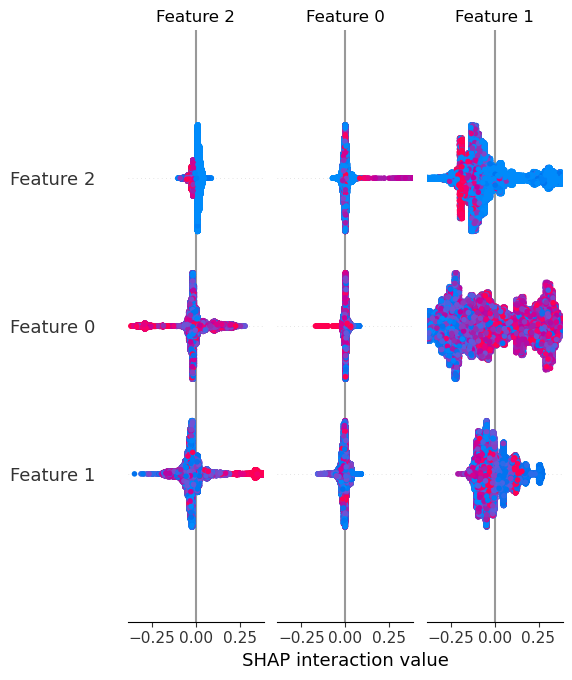

In [ ]:
# Explain model predictions using SHAP
explainer = shap.TreeExplainer(forest_model)
shap_values = explainer.shap_values(X_train_s)

# Plot SHAP values for one prediction
shap.summary_plot(shap_values, X_train_s, feature_names=X_train.columns)

In [ ]:
background = X_train_s[np.random.choice(X_train_s.shape[0], 100, replace=False)]  # Use a background dataset
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values
shap_values = explainer.shap_values(X_train_s)
print(shap_values.shape)

C:\Users\hosse\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
C:\Users\hosse\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor. Received: the structure of inputs=['*']
  warnings.warn(


(54365, 15, 3)


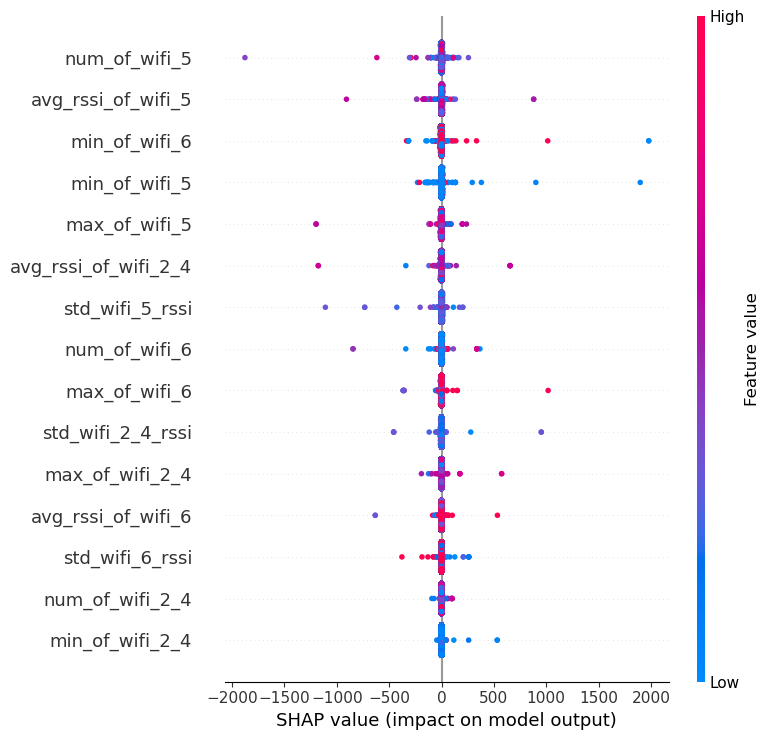

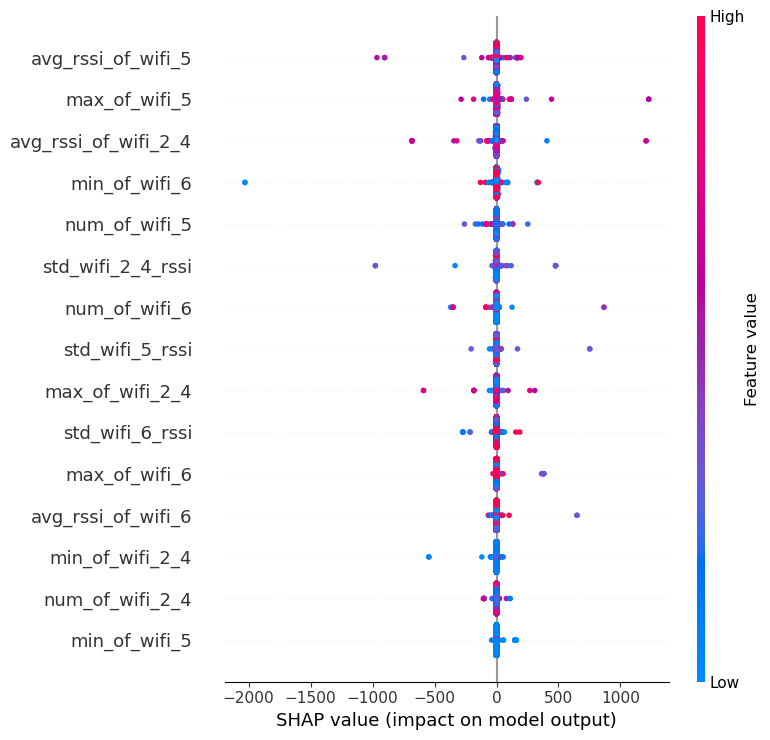

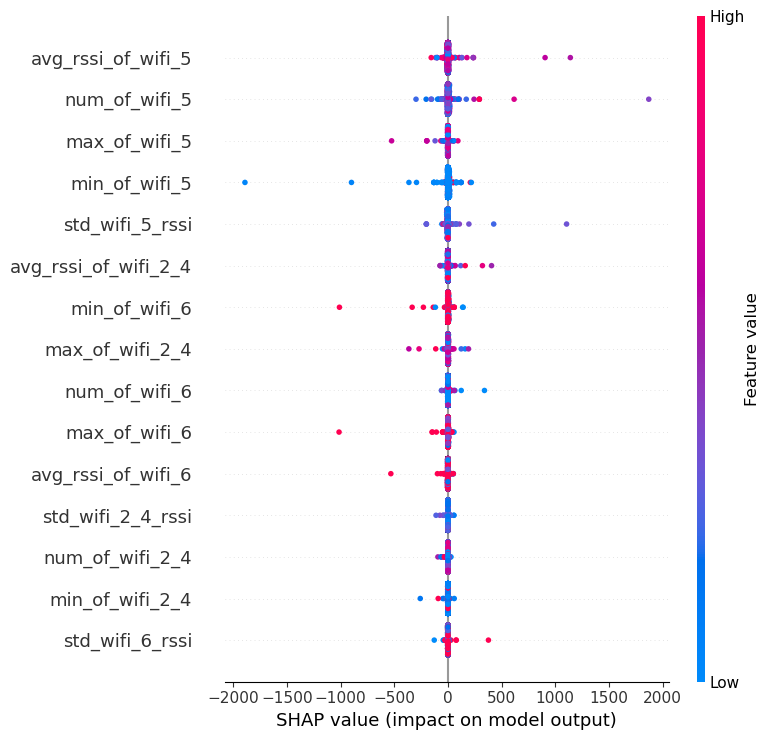

In [ ]:
# Select SHAP values for the first class
for i in range(3):
    shap_values_for_class = shap_values[:, :, i]
    # Plot SHAP summary for the first class
    shap.summary_plot(shap_values_for_class, X_train_s, feature_names=X_train.columns)

In [ ]:
print(type(shap_values))
if isinstance(shap_values, list):
    print("Number of classes:", len(shap_values))
    print("Shape of SHAP values for the first class:", shap_values[0].shape)
else:
    print("Shape of SHAP values:", shap_values.shape)

<class 'numpy.ndarray'>
Shape of SHAP values: (10, 15, 3)


In [ ]:
feature_names = ['Feature %d' % i for i in range(X_train_s.shape[1])]
print("Number of features:", len(feature_names))

Number of features: 15


In [ ]:
shap_values.shape

(10, 15, 3)

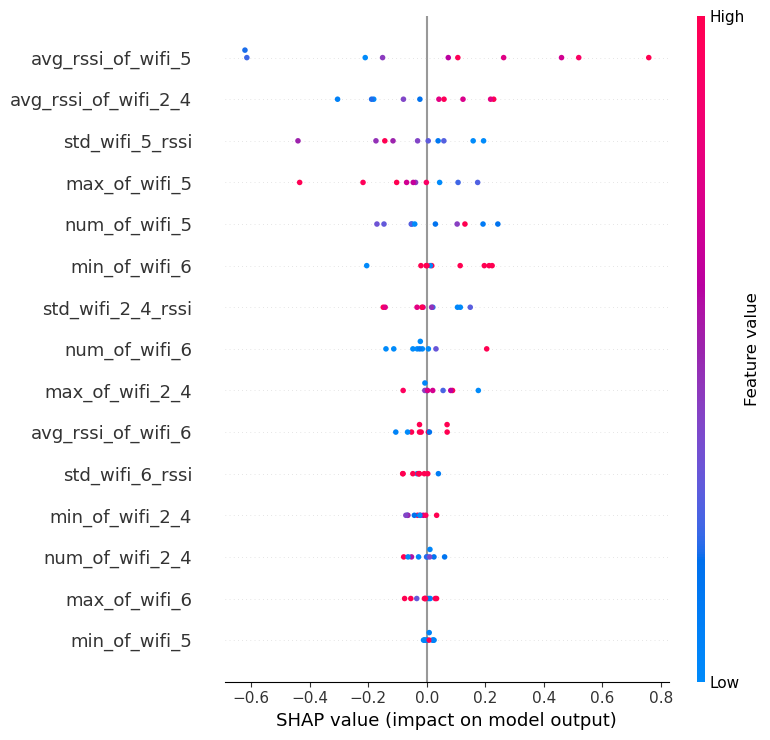

In [ ]:
# Select SHAP values for the first class
class_index = 1
shap_values_for_class = shap_values[:, :, class_index]

# Plot SHAP summary for the first class
shap.summary_plot(shap_values_for_class, X_train_s[:10], feature_names=X_train.columns)


In [ ]:
def test_module(test_data,env):
    if env == 'II':
        test_data['environment']=0
    elif env =='INW':
        test_data['environment']=1
    elif env == 'O':
        test_data['environment']=2
    else:
        print('No such a class')
        return np.nan
    test_data.sort_values(by=['time_counter', 'environment', 'sim_operator'], inplace=True)
    # Apply the grouping function
    grouped_data = form_groups(test_data)
    # Predict for each group and apply majority voting
    final_predictions = []
    True_label=[]

    for group in grouped_data:
        group_df = pd.DataFrame(group)
        X_group = group_df[wifi_columns]  # Assuming wifi_columns are the features for your models
        Y_group=pd.unique(group_df['environment'])
        # Standardize features as the models were trained on standardized data
        X_group_scaled = train_scaler.transform(X_group)

        # Get predictions from each model
        nn_preds = np.argmax(model.predict(X_group_scaled), axis=1)
        dt_preds = tree_model.predict(X_group_scaled)
        rf_preds = forest_model.predict(X_group_scaled)

        # Combine predictions
        all_preds = np.vstack([nn_preds, dt_preds, rf_preds])

        # Vote and select the majority
        voted_class = [majority_vote(all_preds[i, :]) for i in range(3)]
        group_class = majority_vote(voted_class)
        final_predictions.append(voted_class)
        True_label.append(Y_group)

    final_predictions=np.squeeze(np.array(final_predictions))
    True_label=np.squeeze(np.array(True_label))
    # Extract predictions for each classifier
    nn_predictions = final_predictions[:, 0]
    dt_predictions = final_predictions[:, 1]
    rf_predictions = final_predictions[:, 2]

    # Calculate accuracies
    nn_accuracy = accuracy_score(True_label, nn_predictions)
    dt_accuracy = accuracy_score(True_label, dt_predictions)
    rf_accuracy = accuracy_score(True_label, rf_predictions)

    # Calculate confusion matrices
    nn_conf_matrix = confusion_matrix(True_label, nn_predictions)
    dt_conf_matrix = confusion_matrix(True_label, dt_predictions)
    rf_conf_matrix = confusion_matrix(True_label, rf_predictions)

    # Convert confusion matrices to percentages
    nn_conf_matrix_percentage = np.round(nn_conf_matrix.astype('float') / nn_conf_matrix.sum(axis=1)[:, np.newaxis] * 100, 2)
    dt_conf_matrix_percentage = np.round(dt_conf_matrix.astype('float') / dt_conf_matrix.sum(axis=1)[:, np.newaxis] * 100, 2)
    rf_conf_matrix_percentage = np.round(rf_conf_matrix.astype('float') / rf_conf_matrix.sum(axis=1)[:, np.newaxis] * 100, 2)

    # Print results
    print("Neural Network Accuracy:", nn_accuracy)
    print("Neural Network Confusion Matrix:\n", nn_conf_matrix_percentage)

    print("Decision Tree Accuracy:", dt_accuracy)
    print("Decision Tree Confusion Matrix:\n", dt_conf_matrix_percentage)

    print("Random Forest Accuracy:", rf_accuracy)
    print("Random Forest Confusion Matrix:\n", rf_conf_matrix_percentage)


In [ ]:
test_module(pd.read_csv('inw5.csv'),'INW')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

C:\Users\hosse\AppData\Local\Temp\ipykernel_12760\2196630517.py:57: RuntimeWarning: invalid value encountered in divide
  nn_conf_matrix_percentage = np.round(nn_conf_matrix.astype('float') / nn_conf_matrix.sum(axis=1)[:, np.newaxis] * 100, 2)
C:\Users\hosse\AppData\Local\Temp\ipykernel_12760\2196630517.py:58: RuntimeWarning: invalid value encountered in divide
  dt_conf_matrix_percentage = np.round(dt_conf_matrix.astype('float') / dt_conf_matrix.sum(axis=1)[:, np.newaxis] * 100, 2)
C:\Users\hosse\AppData\Local\Temp\ipykernel_12760\2196630517.py:59: RuntimeWarning: invalid value encountered in divide
  rf_conf_matrix_percentage = np.round(rf_conf_matrix.astype('float') / rf_conf_matrix.sum(axis=1)[:, np.newaxis] * 100, 2)
